In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

### Ideal free evolution (no dephasing)

In [2]:
def ramsey_bloch_trajectory(t_free, Ω=2*np.pi*10e6, Δ=2*np.pi*5e6, N=100):
    """
    Simulate Ramsey experiment Bloch trajectory for a given free evolution time t_free.

    Parameters:
        t_free : float
            Free evolution time in seconds.
        Ω : float
            Rabi frequency (default 10 MHz).
        Δ : float
            Detuning frequency (default 5 MHz).
        N : int
            Number of time steps per segment.

    Returns:
        bloch_path : list of lists
            Bloch sphere coordinates [x, y, z] along trajectory.
    """
    t_pi_2 = np.pi / (2 * Ω)
    tlist_pi_2 = np.linspace(0, t_pi_2, N)
    tlist_free = np.linspace(0, t_free, N)
    tlist_final = np.linspace(0, t_pi_2, N)

    psi0 = qt.basis(2, 0)
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()

    # First π/2 pulse
    H1 = 0.5 * Ω * sy
    res1 = qt.mesolve(H1, psi0, tlist_pi_2)
    states1 = res1.states
    psi1_end = states1[-1]

    # Free evolution under detuning
    H2 = 0.5 * Δ * sz
    res2 = qt.mesolve(H2, psi1_end, tlist_free)
    states2 = res2.states
    psi2_end = states2[-1]

    # Final π/2 pulse
    res3 = qt.mesolve(H1, psi2_end, tlist_final)
    states3 = res3.states

    # Combine states
    all_states = states1 + states2 + states3

    # Bloch coordinates
    bloch_path = [
        [qt.expect(sx, s) for s in all_states],
        [qt.expect(sy, s) for s in all_states],
        [qt.expect(sz, s) for s in all_states],
    ]

    return bloch_path

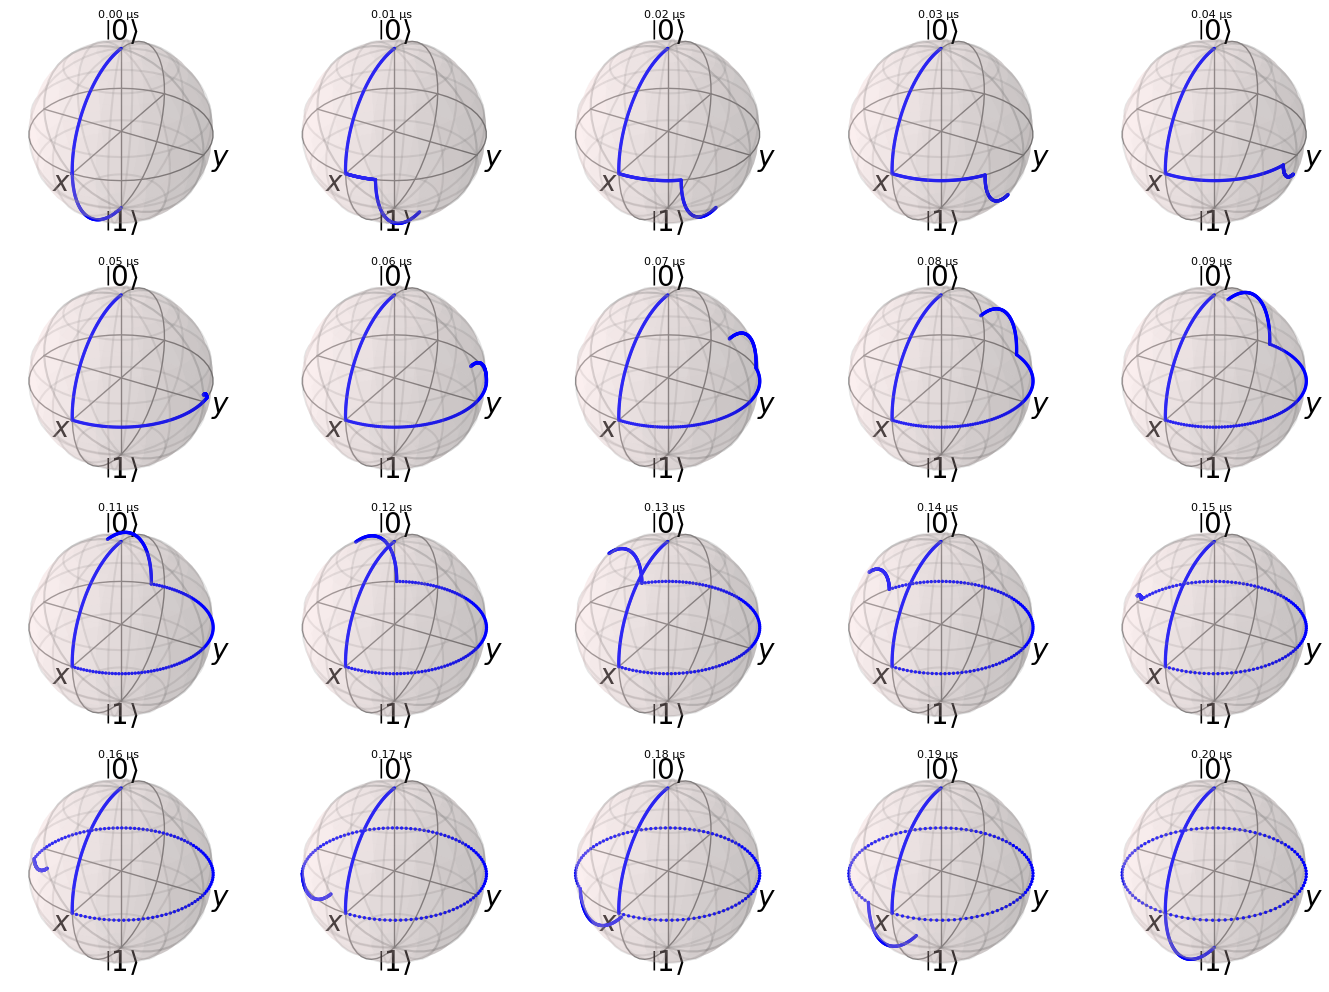

In [6]:
 # Generate 20 t_free values from 0 to 0.1 µs
t_free_values = np.linspace(0, 0.2e-6, 20)

fig = plt.figure(figsize=(14, 10))
for i, t_free in enumerate(t_free_values, 1):
    bloch_path = ramsey_bloch_trajectory(t_free)
    ax = fig.add_subplot(4, 5, i, projection='3d')
    b = qt.Bloch(fig=fig, axes=ax)
    b.view = [40, 35]
    b.point_marker = ['o']
    b.point_size = [2]
    b.add_points(bloch_path)
    b.render()
    ax.set_title(f"{t_free*1e6:.2f} µs", fontsize=8)
plt.tight_layout(pad=1.0)
plt.show()

In [7]:
def ramsey_excited_population(t_free, Ω=2*np.pi*10e6, Δ=2*np.pi*5e6, N=100):
    t_pi_2 = np.pi / (2 * Ω)
    tlist_pi_2 = np.linspace(0, t_pi_2, N)
    tlist_free = np.linspace(0, t_free, N)
    tlist_final = np.linspace(0, t_pi_2, N)

    psi0 = qt.basis(2, 0)
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
    excited_state = qt.basis(2, 1)  # |1>

    H1 = 0.5 * Ω * sy
    res1 = qt.mesolve(H1, psi0, tlist_pi_2)
    psi1_end = res1.states[-1]

    H2 = 0.5 * Δ * sz
    res2 = qt.mesolve(H2, psi1_end, tlist_free)
    psi2_end = res2.states[-1]

    res3 = qt.mesolve(H1, psi2_end, tlist_final)
    psi_final = res3.states[-1]

    # Excited state probability after final pulse
    p_excited = abs(psi_final.overlap(excited_state))**2

    return p_excited

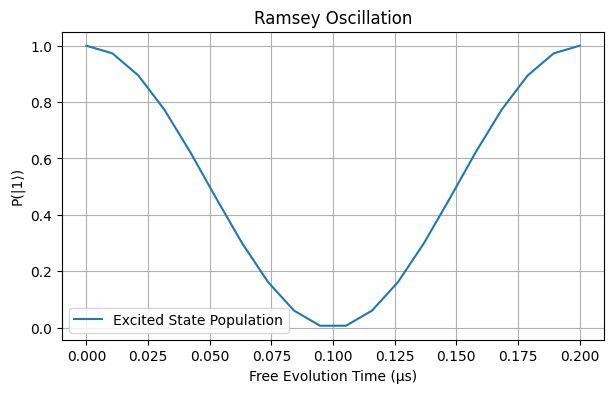

In [8]:
t_free_values = np.linspace(0, 0.2e-6, 20)
populations = [ramsey_excited_population(t) for t in t_free_values]

plt.figure(figsize=(7, 4))
plt.plot(t_free_values * 1e6, populations, label='Excited State Population')
plt.xlabel('Free Evolution Time (µs)')
plt.ylabel('P(|1⟩)')
plt.title('Ramsey Oscillation')
plt.grid(True)
plt.legend()
plt.show()


### With dephasing (decay to Bloch sphere centre)

In [20]:
def ramsey_bloch_trajectory(t_free, Ω=2*np.pi*10e6, Δ=2*np.pi*5e6, T2=30e-6, N=500):
    """
    Simulate Ramsey experiment Bloch trajectory for a given free evolution time t_free.

    Parameters:
        t_free : float
            Free evolution time in seconds.
        Ω : float
            Rabi frequency (default 10 MHz).
        Δ : float
            Detuning frequency (default 5 MHz).
        N : int
            Number of time steps per segment.

    Returns:
        bloch_path : list of lists
            Bloch sphere coordinates [x, y, z] along trajectory.
    """
    t_pi_2 = np.pi / (2 * Ω)
    tlist_pi_2 = np.linspace(0, t_pi_2, N)
    tlist_free = np.linspace(0, t_free, N)
    tlist_final = np.linspace(0, t_pi_2, N)

    psi0 = qt.basis(2, 0)
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()

    # Dephasing collapse operator
    gamma_phi = 1 / T2
    c_ops_free = [np.sqrt(gamma_phi) * sz]

    # First π/2 pulse
    H1 = 0.5 * Ω * sy
    res1 = qt.mesolve(H1, psi0, tlist_pi_2, c_ops=c_ops_free)
    states1 = res1.states
    psi1_end = states1[-1]

    # Free evolution under detuning
    H2 = 0.5 * Δ * sz
    res2 = qt.mesolve(H2, psi1_end, tlist_free, c_ops=c_ops_free)
    states2 = res2.states
    psi2_end = states2[-1]

    # Final π/2 pulse
    res3 = qt.mesolve(H1, psi2_end, tlist_final, c_ops=c_ops_free)
    states3 = res3.states

    # Combine states
    all_states = states1 + states2 + states3

    # Bloch coordinates
    bloch_path = [
        [qt.expect(sx, s) for s in all_states],
        [qt.expect(sy, s) for s in all_states],
        [qt.expect(sz, s) for s in all_states],
    ]

    return bloch_path

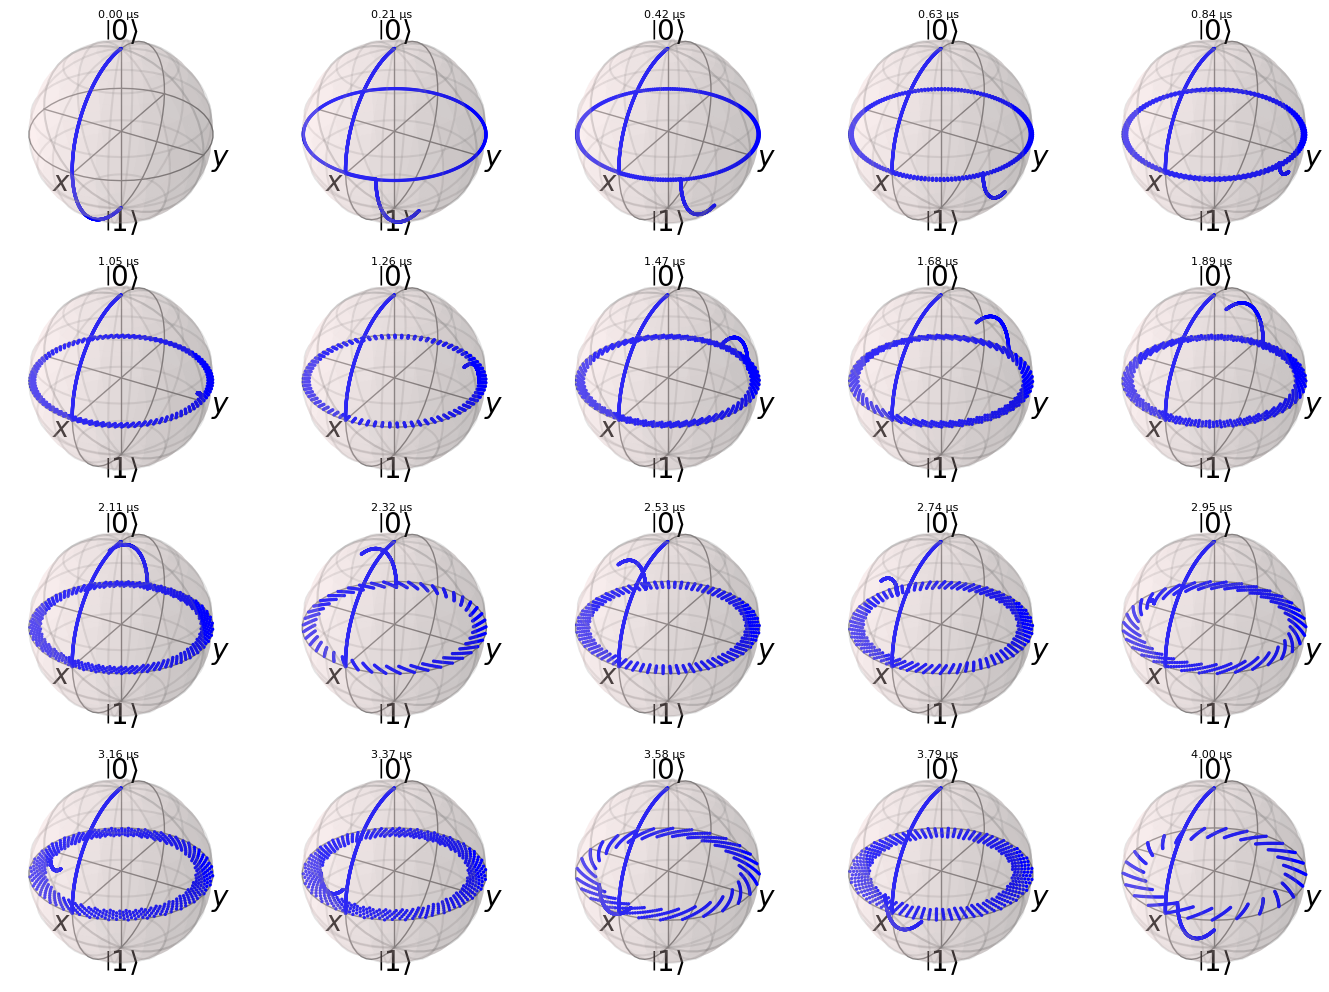

In [21]:
 # Generate 20 t_free values from 0 to 4 µs
t_free_values = np.linspace(0, 4e-6, 20)

fig = plt.figure(figsize=(14, 10))
for i, t_free in enumerate(t_free_values, 1):
    bloch_path = ramsey_bloch_trajectory(t_free)
    ax = fig.add_subplot(4, 5, i, projection='3d')
    b = qt.Bloch(fig=fig, axes=ax)
    b.view = [40, 35]
    b.point_marker = ['o']
    b.point_size = [2]
    b.add_points(bloch_path)
    b.render()
    ax.set_title(f"{t_free*1e6:.2f} µs", fontsize=8)
plt.tight_layout(pad=1.0)
plt.show()

In [14]:
def ramsey_excited_population_dephasing(t_free, Ω=2*np.pi*10e6, Δ=2*np.pi*5e6, T2=5e-6, N=100):
    t_pi_2 = np.pi / (2 * Ω)
    tlist_pi_2 = np.linspace(0, t_pi_2, N)
    tlist_free = np.linspace(0, t_free, N)
    tlist_final = np.linspace(0, t_pi_2, N)

    psi0 = qt.basis(2, 0)
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
    excited_state = qt.basis(2, 1)

    H1 = 0.5 * Ω * sy
    H2 = 0.5 * Δ * sz

    # Dephasing collapse operator
    gamma_phi = 1 / T2
    c_ops_free = [np.sqrt(gamma_phi) * sz]
    c_ops_no = []  # No collapse during pulses (assuming fast pulses)

    # First π/2 pulse (no dephasing)
    res1 = qt.mesolve(H1, psi0, tlist_pi_2, c_ops_no)
    psi1_end = res1.states[-1]

    # Free evolution with dephasing
    res2 = qt.mesolve(H2, psi1_end, tlist_free, c_ops_free)
    psi2_end = res2.states[-1]

    # Final π/2 pulse (no dephasing)
    res3 = qt.mesolve(H1, psi2_end, tlist_final, c_ops_no)
    psi_final = res3.states[-1]

    p_excited = abs(psi_final.overlap(excited_state))**2
    return p_excited


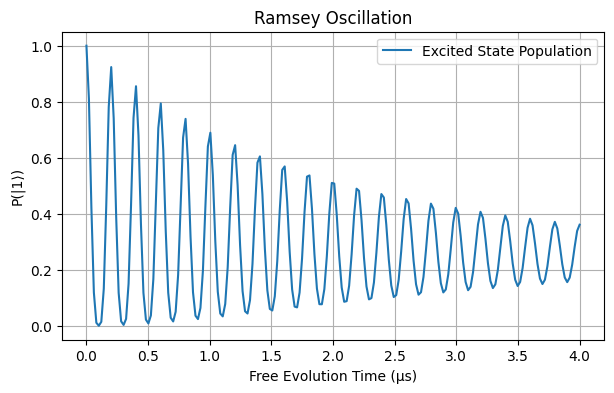

In [17]:
t_free_values = np.linspace(0, 4e-6, 200)
populations = [ramsey_excited_population_dephasing(t) for t in t_free_values]

plt.figure(figsize=(7, 4))
plt.plot(t_free_values * 1e6, populations, label='Excited State Population')
plt.xlabel('Free Evolution Time (µs)')
plt.ylabel('P(|1⟩)')
plt.title('Ramsey Oscillation')
plt.grid(True)
plt.legend()
plt.show()
